In [11]:
import torch
from datasets import BitStringDataset
import lovely_tensors as lt
import wandb
import tqdm
from einops import rearrange, reduce, repeat
from models import (SupervenientFeatureNetwork,
                    CLUB,
                    DecoupledSmileMIEstimator,
                    DownwardSmileMIEstimator,
                    GeneralSmileMIEstimator,
                    SkipConnectionSupervenientFeatureNetwork
                    )
lt.monkey_patch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()


In [12]:
def train_feature_network(config, trainloader, feature_network):

    wandb.init(project="bits-dataset-neurips", config=config)
    # init weights to zero of the feature network

    decoupled_MI_estimator = DecoupledSmileMIEstimator(
        feature_size=config['feature_size'],
        critic_output_size=config['critic_output_size'],
        hidden_sizes_1=config['decoupled_critic_hidden_sizes_1'],
        hidden_sizes_2=config['decoupled_critic_hidden_sizes_2'],
        clip=config['clip'],
        include_bias=config['bias']
        ).to(device)
    downward_MI_estimators = [
        DownwardSmileMIEstimator(
            feature_size=config['feature_size'],
            critic_output_size=config['critic_output_size'],
            hidden_sizes_v_critic=config['downward_hidden_sizes_v_critic'],
            hidden_sizes_xi_critic=config['downward_hidden_sizes_xi_critic'],
            clip=config['clip'],
            include_bias=config['bias']
            ).to(device) 
        for _ in range(config['num_atoms'])
    ]
    xor_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)

    extra_bit_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)

    bonus_bit_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)

    

    feature_optimizer = torch.optim.Adam(
        feature_network.parameters(),
        lr=config["feature_lr"],
        weight_decay=config["weight_decay"]
    )
    decoupled_optimizer = torch.optim.Adam(
        decoupled_MI_estimator.parameters(),
        lr=config["decoupled_critic_lr"],
        weight_decay=config["weight_decay"]
    )
    downward_optims = [
        torch.optim.Adam(
            dc.parameters(),
            lr=config["downward_lr"],
            weight_decay=config["weight_decay"]
        ) 
        for dc in downward_MI_estimators
    ]
    xor_optimizer = torch.optim.Adam(
        xor_estimator.parameters(),
        lr=1e-4,
        weight_decay=config["weight_decay"]
    )

    extra_bit_optimizer = torch.optim.Adam(
        extra_bit_estimator.parameters(),
        lr=1e-4,
        weight_decay=config["weight_decay"]
    )

    bonus_bit_optimizer = torch.optim.Adam(
        bonus_bit_estimator.parameters(),
        lr=1e-4,
        weight_decay=config["weight_decay"]
    )



    # TODO: figure out why only f network is being watched, I would like to keep a closer eye on the grad n params.
    # TODO: Look at how GANs are trained with pytorch and make sure I'm not doing anything unreasonable.
    # Eg, https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py 
    # ^ this does not require retain_graph=True, so maybe this can be optomized somehow
    wandb.watch(feature_network, log='all')
    wandb.watch(decoupled_MI_estimator, log="all")
    for dc in downward_MI_estimators:
        wandb.watch(dc, log='all')

    ##
    ## TRAIN FEATURE NETWORK
    ##

    epochs = config['epochs']

    step = 0

    for _ in tqdm.tqdm(range(epochs), desc='Training'):
        for batch_num, batch in enumerate(trainloader):
            x0 = batch[:, 0].to(device).float()
            x1 = batch[:, 1].to(device).float()
            v0 = feature_network(x0).detach()
            v1 = feature_network(x1).detach()

            # update decoupled critic
            decoupled_optimizer.zero_grad()
            decoupled_MI = decoupled_MI_estimator(v0, v1)
            decoupled_loss = -decoupled_MI
            decoupled_loss.backward(retain_graph=True)
            decoupled_optimizer.step()

            # update each downward critic 
            for i in range(config['num_atoms']):
                downward_optims[i].zero_grad()
                channel_i = x0[:, i].unsqueeze(1).detach()
                downward_MI_i = downward_MI_estimators[i](v1, channel_i)
                downward_loss = - downward_MI_i
                downward_loss.backward(retain_graph=True)
                downward_optims[i].step()
                wandb.log({
                    f"downward_MI_{i}": downward_MI_i   
                })

            # update feature network
            feature_optimizer.zero_grad()
            channel_MIs = []

            # MIs = []
            v0 = feature_network(x0)
            v1 = feature_network(x1)

            for i in range(config['num_atoms']):
                channel_i = x0[:, i].unsqueeze(1)
                channel_i_MI = downward_MI_estimators[i](v1, channel_i)
                channel_MIs.append(channel_i_MI)
                # MIs.append(channel_i_MI)

            sum_downward_MI = sum(channel_MIs)

            decoupled_MI1 = decoupled_MI_estimator(v0, v1)

            #clipped_min_MIs = max(0, min(MIs))

            Psi = decoupled_MI1 - sum_downward_MI #+ (config['num_atoms'] - 1) * clipped_min_MIs
            #NOTE LOSS CHANGEDDDDD
            feature_loss = sum_downward_MI
            if config['start_updating_f_after'] < step:
                if batch_num % config['update_f_every_N_steps'] == 0:
                    feature_loss.backward(retain_graph=True)
                    feature_optimizer.step()

            wandb.log({
                "decoupled_MI": decoupled_MI1,
                "sum_downward_MI": sum_downward_MI,
                "Psi": Psi,
            }, step=step)




            v0 = feature_network(x0).detach()
            v1 = feature_network(x1).detach()
            xor_bits = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)
            extra_bit = x0[:, -1].unsqueeze(1)
            bonus_bit = ( xor_bits + extra_bit ) % 2


            xor_optimizer.zero_grad()
            xor_MI = xor_estimator(v0, xor_bits)
            xor_loss = -xor_MI
            xor_loss.backward(retain_graph=True)
            xor_optimizer.step()

            extra_bit_optimizer.zero_grad()
            extra_bit_MI = extra_bit_estimator(v0, extra_bit)
            extra_bit_loss = -extra_bit_MI
            extra_bit_loss.backward(retain_graph=True)
            extra_bit_optimizer.step()

            bonus_bit_optimizer.zero_grad()
            bonus_bit_MI = bonus_bit_estimator(v0, bonus_bit)
            bonus_bit_loss = -bonus_bit_MI
            bonus_bit_loss.backward(retain_graph=True)
            bonus_bit_optimizer.step()

            wandb.log({
                "xor_MI": xor_MI,
                "extra_bit_MI": extra_bit_MI,
                "bonus_bit_MI": bonus_bit_MI
            }, step=step)

            step += 1
        
    torch.save(feature_network.state_dict(), f"models/feature_network_{wandb.run.name}.pth")
    
    return feature_network



In [13]:
def train_feature_network_B(config, trainloader, feature_network_A, feature_network_B):

    wandb.init(project="bits-dataset-neurips", config=config)
    # init weights to zero of the feature network

    decoupled_MI_estimator = DecoupledSmileMIEstimator(
        feature_size=config['feature_size'],
        critic_output_size=config['critic_output_size'],
        hidden_sizes_1=config['decoupled_critic_hidden_sizes_1'],
        hidden_sizes_2=config['decoupled_critic_hidden_sizes_2'],
        clip=config['clip'],
        include_bias=config['bias']
        ).to(device)
    downward_MI_estimators = [
        DownwardSmileMIEstimator(
            feature_size=config['feature_size'],
            critic_output_size=config['critic_output_size'],
            hidden_sizes_v_critic=config['downward_hidden_sizes_v_critic'],
            hidden_sizes_xi_critic=config['downward_hidden_sizes_xi_critic'],
            clip=config['clip'],
            include_bias=config['bias']
            ).to(device) 
        for _ in range(config['num_atoms'])
    ]
    MI_AB_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=config['feature_size'],
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)
    xor_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)
    extra_bit_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)
    bonus_bit_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)

    

    feature_optimizer = torch.optim.Adam(
        feature_network_B.parameters(),
        lr=config["feature_lr"],
        weight_decay=config["weight_decay"]
    )
    decoupled_optimizer = torch.optim.Adam(
        decoupled_MI_estimator.parameters(),
        lr=config["decoupled_critic_lr"],
        weight_decay=config["weight_decay"]
    )
    downward_optims = [
        torch.optim.Adam(
            dc.parameters(),
            lr=config["downward_lr"],
            weight_decay=config["weight_decay"]
        ) 
        for dc in downward_MI_estimators
    ]
    MI_AB_optimizer = torch.optim.Adam(
        MI_AB_estimator.parameters(),
        lr=1e-3,
        weight_decay=config["weight_decay"]
    )
    xor_optimizer = torch.optim.Adam(
        xor_estimator.parameters(),
        lr=1e-3,
        weight_decay=config["weight_decay"]
    )
    extra_bit_optimizer = torch.optim.Adam(
        extra_bit_estimator.parameters(),
        lr=1e-3,
        weight_decay=config["weight_decay"]
    )
    bonus_bit_optimizer = torch.optim.Adam(
        bonus_bit_estimator.parameters(),
        lr=1e-3,
        weight_decay=config["weight_decay"]
    )



    # TODO: figure out why only f network is being watched, I would like to keep a closer eye on the grad n params.
    # TODO: Look at how GANs are trained with pytorch and make sure I'm not doing anything unreasonable.
    # Eg, https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py 
    # ^ this does not require retain_graph=True, so maybe this can be optomized somehow
    wandb.watch(feature_network_B, log='all')
    wandb.watch(decoupled_MI_estimator, log="all")
    for dc in downward_MI_estimators:
        wandb.watch(dc, log='all')

    ##
    ## TRAIN FEATURE NETWORK
    ##

    epochs = config['epochs']

    step = 0

    for _ in tqdm.tqdm(range(epochs), desc='Training'):
        for batch_num, batch in enumerate(trainloader):

            x0 = batch[:, 0].to(device).float()
            x1 = batch[:, 1].to(device).float()
            v0_B = feature_network_B(x0).detach()
            v1_B = feature_network_B(x1).detach()
            v0_A = feature_network_A(x0).detach()


            # update decoupled critic
            decoupled_optimizer.zero_grad()
            decoupled_MI = decoupled_MI_estimator(v0_B, v1_B)
            decoupled_loss = -decoupled_MI
            decoupled_loss.backward(retain_graph=True)
            decoupled_optimizer.step()


            # update each downward critic 
            for i in range(config['num_atoms']):
                downward_optims[i].zero_grad()
                channel_i = x0[:, i].unsqueeze(1).detach()
                downward_MI_i = downward_MI_estimators[i](v1_B, channel_i)
                downward_loss = - downward_MI_i
                downward_loss.backward(retain_graph=True)
                downward_optims[i].step()
                # wandb.log({
                #     f"downward_MI_{i}": downward_MI_i   
                # })


            # update MI_AB critic
            MI_AB_optimizer.zero_grad()
            MI_AB = MI_AB_estimator(v0_B, v0_A)
            MI_AB_loss = -MI_AB
            MI_AB_loss.backward(retain_graph=True)
            MI_AB_optimizer.step()
            wandb.log({"MI_AB": MI_AB},step=step)


            # update feature network
            feature_optimizer.zero_grad()
            channel_MIs = []

            # MIs = []
            v0_B = feature_network_B(x0)
            v1_B = feature_network_B(x1)

            for i in range(config['num_atoms']):
                channel_i = x0[:, i].unsqueeze(1)
                channel_i_MI = downward_MI_estimators[i](v1_B, channel_i)
                channel_MIs.append(channel_i_MI)
                # MIs.append(channel_i_MI)

            sum_downward_MI = sum(channel_MIs)
            decoupled_MI1 = decoupled_MI_estimator(v0_B, v1_B)
            MI_AB = MI_AB_estimator(v0_B, v0_A)

            #clipped_min_MIs = max(0, min(MIs))

            Psi = decoupled_MI1 - sum_downward_MI - MI_AB #+ (config['num_atoms'] - 1) * clipped_min_MIs
            feature_loss = -Psi
            if config['start_updating_f_after'] < step:
                if batch_num % config['update_f_every_N_steps'] == 0:
                    feature_loss.backward(retain_graph=True)
                    feature_optimizer.step()

            if config['start_updating_f_after'] == step:
                print("Starting to update feature network B")

            wandb.log({
                "decoupled_MI": decoupled_MI1,
                "sum_downward_MI": sum_downward_MI,
                "Psi": Psi,
            },step=step)



            v0_B = feature_network_B(x0).detach()
            v1_B = feature_network_B(x1).detach()
            xor_bits = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)
            extra_bit = x0[:, -1].unsqueeze(1)
            bonus_bit = ( xor_bits + extra_bit ) % 2


            xor_optimizer.zero_grad()
            xor_MI = xor_estimator(v0_B, xor_bits)
            xor_loss = -xor_MI
            xor_loss.backward(retain_graph=True)
            xor_optimizer.step()

            extra_bit_optimizer.zero_grad()
            extra_bit_MI = extra_bit_estimator(v0_B, extra_bit)
            extra_bit_loss = -extra_bit_MI
            extra_bit_loss.backward(retain_graph=True)
            extra_bit_optimizer.step()

            bonus_bit_optimizer.zero_grad()
            bonus_bit_MI = bonus_bit_estimator(v0_B, bonus_bit)
            bonus_bit_loss = -bonus_bit_MI
            bonus_bit_loss.backward(retain_graph=True)
            bonus_bit_optimizer.step()

            wandb.log({
                "xor_MI": xor_MI,
                "extra_bit_MI": extra_bit_MI,
                "bonus_bit_MI": bonus_bit_MI
            },step=step)

            step += 1



        
    torch.save(feature_network_B.state_dict(), f"models/feature_network_{wandb.run.name}.pth")
    
    return feature_network_B



In [14]:
config = {
    "num_data_points": int(1e6),
    "extra_bit_correlation": 0.99,
    "parity_bit_correlation": 0.99,
    "epochs": 20,
    "batch_size": 1000,
    "num_atoms": 6,
    "feature_size": 1,
    "clip": 5,
    "critic_output_size": 32,
    "downward_hidden_sizes_v_critic": [512, 512, 512, 256],
    "downward_hidden_sizes_xi_critic": [512, 512, 512, 256],
    "feature_hidden_sizes": [256, 256, 256],
    "decoupled_critic_hidden_sizes_1": [512, 512, 512],
    "decoupled_critic_hidden_sizes_2": [512, 512, 512],
    "feature_lr": 0.00001,
    "decoupled_critic_lr": 1e-3,
    "downward_lr": 1e-3,    
    "bias": True,
    "update_f_every_N_steps": 10,
    "weight_decay": 0,
    "start_updating_f_after": 1000,
}



In [15]:


dataset = BitStringDataset(
    gamma_parity=config['parity_bit_correlation'],
    gamma_extra=config['extra_bit_correlation'],
    length=config['num_data_points'],
)

trainloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=config['batch_size'],
    shuffle=True,
)

In [9]:
# trainin a model B using a model A that learned the XOR bit.
feature_network_A = SkipConnectionSupervenientFeatureNetwork(
    num_atoms=config['num_atoms'],
    feature_size=config['feature_size'],
    hidden_sizes=config['feature_hidden_sizes'],
    include_bias=config['bias']
    ).to(device)

model_A_path = '/vol/bitbucket/dm2223/info-theory-experiments/models/feature_network_apricot-pond-70.pth'
feature_network_A.load_state_dict(torch.load(model_A_path))

feature_network_B = SkipConnectionSupervenientFeatureNetwork(
    num_atoms=config['num_atoms'],
    feature_size=config['feature_size'],
    hidden_sizes=config['feature_hidden_sizes'],
    include_bias=config['bias']
    ).to(device)

feature_network_B = train_feature_network_B(config, trainloader, feature_network_A, feature_network_B)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dmcsharry. Use `wandb login --relogin` to force relogin


Training:   5%|▌         | 1/20 [00:37<11:49, 37.35s/it]

Starting to update feature network B


Training: 100%|██████████| 20/20 [11:45<00:00, 35.27s/it]


In [7]:

# NOTE: the Psi here isnt really Psi, what we should do instead here is add I(va,vb) in loss but keep track of true loss, 
# maybe add a smaller coeeficient for I(va,vb) term in the loss
def find_true_Psi(feature_network, run_id, trainloader):

    config = {
        "epochs": 1,
        "batch_size": 1000,
        "num_atoms": 6,
        "feature_size": feature_network.feature_size,
        "clip": 5,
        "critic_output_size": 16,
        "downward_hidden_sizes_v_critic": [512, 512, 128],
        "downward_hidden_sizes_xi_critic": [512, 512, 128],
        "decoupled_critic_hidden_sizes_1": [512, 512, 128],
        "decoupled_critic_hidden_sizes_2": [512, 512, 128],
        "decoupled_critic_lr": 1e-3,
        "downward_lr": 1e-3,
        "bias": True,
        "weight_decay": 0,
        "original_run_id": run_id
    }

    wandb.init(project="BITS_Finding-true-Psi-for-f", config=config, id=run_id)

    decoupled_critic = DecoupledSmileMIEstimator(
        feature_size=config['feature_size'],
        critic_output_size=config['critic_output_size'],
        hidden_sizes_1=config['decoupled_critic_hidden_sizes_1'],
        hidden_sizes_2=config['decoupled_critic_hidden_sizes_2'],
        clip=config['clip'],
        include_bias=config['bias']
        ).to(device)

    downward_critics = [
        DownwardSmileMIEstimator(
            feature_size=config['feature_size'],
            critic_output_size=config['critic_output_size'],
            hidden_sizes_v_critic=config['downward_hidden_sizes_v_critic'],
            hidden_sizes_xi_critic=config['downward_hidden_sizes_xi_critic'],
            clip=config['clip'],
            include_bias=config['bias']
            ).to(device) 
        for _ in range(config['num_atoms'])
    ]

    xor_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)

    extra_bit_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)

    bonus_bit_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)


    downward_optims = [
        torch.optim.Adam(
            dc.parameters(),
            lr=config["downward_lr"],
            weight_decay=config["weight_decay"]
        ) 
        for dc in downward_critics
    ]

    decoupled_optimizer = torch.optim.Adam(
        decoupled_critic.parameters(),
        lr=config["decoupled_critic_lr"],
        weight_decay=config["weight_decay"]
    )

    xor_optimizer = torch.optim.Adam(
        xor_estimator.parameters(),
        lr=config["decoupled_critic_lr"],
        weight_decay=config["weight_decay"]
    )

    extra_bit_optimizer = torch.optim.Adam(
        extra_bit_estimator.parameters(),
        lr=config["decoupled_critic_lr"],
        weight_decay=config["weight_decay"]
    )

    bonus_bit_optimizer = torch.optim.Adam(
        bonus_bit_estimator.parameters(),
        lr=config["decoupled_critic_lr"],
        weight_decay=config["weight_decay"]
    )


    # TODO: figure out why only f network is being watched, I would like to keep a closer eye on the grad n params.
    # TODO: Look at how GANs are trained with pytorch and make sure I'm not doing anything unreasonable.
    # Eg, https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py 
    # ^ this does not require retain_graph=True, so maybe this can be optomized somehow
    wandb.watch(decoupled_critic, log="all")
    for dc in downward_critics:
        wandb.watch(dc, log='all')

    epochs = config['epochs']

    for _ in tqdm.tqdm(range(epochs), desc='Training'):
        for _, batch in enumerate(trainloader):
            x0 = batch[:, 0].to(device).float()
            x1 = batch[:, 1].to(device).float()

            # update decoupled critic

            v0 = feature_network(x0)
            v1 = feature_network(x1) 

            xor_bits = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)
            extra_bit = x0[:, -1].unsqueeze(1)
            bonus_bit = ( xor_bits + extra_bit ) % 2


            decoupled_optimizer.zero_grad()
            decoupled_MI = decoupled_critic(v0, v1)
            decoupled_loss = -decoupled_MI
            decoupled_loss.backward(retain_graph=True)
            decoupled_optimizer.step()


            # update each downward critic 

            MIs = []

            for i in range(config['num_atoms']):
                downward_optims[i].zero_grad()
                channel_i = x0[:, i].unsqueeze(1)
                downward_MI_i = downward_critics[i](v1, channel_i)
                # add spectral norm to the loss
                downward_loss = - downward_MI_i
                downward_loss.backward(retain_graph=True)
                downward_optims[i].step()
                # wandb.log({
                #     f"downward_MI_{i}": downward_MI_i   
                # })
                MIs.append(downward_MI_i)

            # update feature network   

            min_MI = min(MIs)
            clipped_min_MIs = max(0, min_MI)

            sum_downward_MI = 0

            for i in range(config['num_atoms']):
                channel_i = x0[:, i].unsqueeze(1)
                sum_downward_MI += downward_critics[i](v1, channel_i)

            decoupled_MI1 = decoupled_critic(v0, v1)

            Psi = decoupled_MI1 - sum_downward_MI + (config['num_atoms'] - 1) * clipped_min_MIs

            wandb.log({
                "decoupled_MI": decoupled_MI1,
                "sum_downward_MI": sum_downward_MI,
                "Psi": Psi,
            })

            xor_optimizer.zero_grad()
            xor_MI = xor_estimator(v0, xor_bits)
            xor_loss = -xor_MI
            xor_loss.backward(retain_graph=True)
            xor_optimizer.step()

            extra_bit_optimizer.zero_grad()
            extra_bit_MI = extra_bit_estimator(v0, extra_bit)
            extra_bit_loss = -extra_bit_MI
            extra_bit_loss.backward(retain_graph=True)
            extra_bit_optimizer.step()

            bonus_bit_optimizer.zero_grad()
            bonus_bit_MI = bonus_bit_estimator(v0, bonus_bit)
            bonus_bit_loss = -bonus_bit_MI
            bonus_bit_loss.backward(retain_graph=True)
            bonus_bit_optimizer.step()

            wandb.log({
                "xor_MI": xor_MI,
                "extra_bit_MI": extra_bit_MI,
                "bonus_bit_MI": bonus_bit_MI
            })
            
        
    return Psi


In [7]:
feature_network = SkipConnectionSupervenientFeatureNetwork(
    num_atoms=config['num_atoms'],
    feature_size=config['feature_size'],
    hidden_sizes=config['feature_hidden_sizes'],
    include_bias=config['bias']
    ).to(device)

Psi = find_true_Psi(feature_network, None, trainloader)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dmcsharry. Use `wandb login --relogin` to force relogin


Training: 100%|██████████| 1/1 [00:30<00:00, 30.12s/it]


In [22]:
feature_network = SkipConnectionSupervenientFeatureNetwork(
    num_atoms=config['num_atoms'],
    feature_size=config['feature_size'],
    hidden_sizes=config['feature_hidden_sizes'],
    include_bias=config['bias']
    ).to(device)


feature_network = train_feature_network(config, trainloader, feature_network)

Psi,▄▂▃▃▂▁▁▂▂▁▄▃▄▃▄▅▅▅▃▄▄▅▅█▅▄▅▆▆▆▅▆▆▅▅▆▆▇▇▇
bonus_bit_MI,▁▅▆█▇████▆▅▆▆▇▆▅▄▅▃▄▅▃▅▄▃▄▅▃▅▅▂▃▃▃▂▂▂▂▁▂
decoupled_MI,▅▃▅█▆▃▅▆▅▇▄▂▁▁▃▂▁▁▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂▄
extra_bit_MI,▇▇▆▇▇▆▆█▇▇▆▅▄▅▄▄▃▃▄▄▄▃▃▂▂▄▂▂▂▂▃▂▁▁▂▁▁▂▂▂
sum_downward_MI,▅▆▆▇▇▇█▇▇█▅▆▄▅▅▄▄▄▅▅▄▄▄▁▃▄▄▃▃▃▃▃▂▃▃▂▃▂▂▂
xor_MI,▁▁▂▂▂▁▂▃▃▂▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▂▂▃▃▄▅▆▄▅▅▇▆█
Psi,6e-05
bonus_bit_MI,0.02731
decoupled_MI,0.01176
extra_bit_MI,0.00567
sum_downward_MI,0.01169


Training: 100%|██████████| 20/20 [09:07<00:00, 27.38s/it]


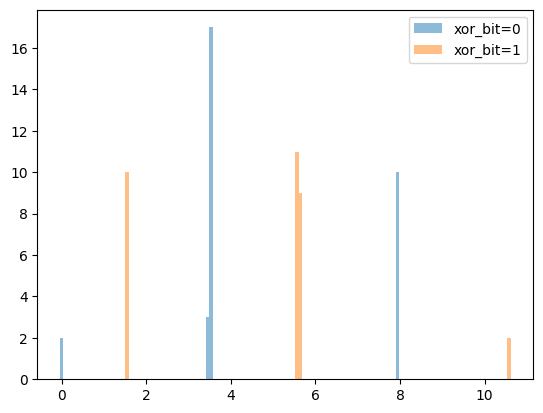

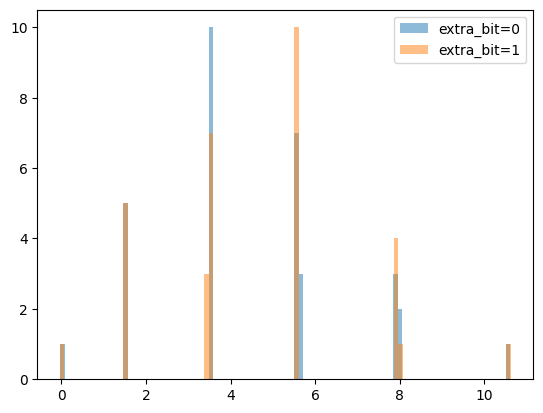

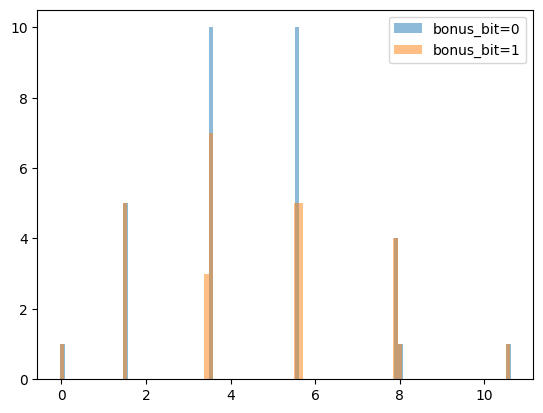

In [25]:

# plot the various values of V to visually inspect if they contain information about the different bits
feature_network = SkipConnectionSupervenientFeatureNetwork(
    num_atoms=config['num_atoms'],
    feature_size=config['feature_size'],
    hidden_sizes=config['feature_hidden_sizes'],
    include_bias=config['bias']
    ).to(device)

# load /vol/bitbucket/dm2223/info-theory-experiments/models/feature_network_apricot-pond-70.pth

feature_network.load_state_dict(torch.load('/vol/bitbucket/dm2223/info-theory-experiments/models/feature_network_apricot-pond-70.pth'))

binary_numbers = torch.tensor([[int(bit) for bit in f"{i:06b}"] for i in range(2**6)])

v = feature_network(binary_numbers.float().to(device))

xor_bits = (reduce(binary_numbers[:, :5], 'b n -> b', 'sum') % 2).unsqueeze(1)

# plot the different values of v on a histogram, with different colors for the two different xor bits

import matplotlib.pyplot as plt
import numpy as np

v_np = v.detach().cpu().numpy()
xor_bits_np = xor_bits.cpu().numpy()

plt.hist(v_np[xor_bits_np == 0], bins=100, alpha=0.5, label='xor_bit=0')
plt.hist(v_np[xor_bits_np == 1], bins=100, alpha=0.5, label='xor_bit=1')
plt.legend()
plt.show()


extra_bits = binary_numbers[:, -1].unsqueeze(1)

# plot the different values of v on a histogram, with different colors for the two different extra bits


plt.hist(v_np[extra_bits == 0], bins=100, alpha=0.5, label='extra_bit=0')
plt.hist(v_np[extra_bits == 1], bins=100, alpha=0.5, label='extra_bit=1')
plt.legend()
plt.show()


bonus_bits = ( xor_bits + extra_bits ) % 2

# plot the different values of v on a histogram, with different colors for the two different bonus bits


plt.hist(v_np[bonus_bits == 0], bins=100, alpha=0.5, label='bonus_bit=0')
plt.hist(v_np[bonus_bits == 1], bins=100, alpha=0.5, label='bonus_bit=1')
plt.legend()
plt.show()



In [24]:
bits = torch.tensor([1,0,0,0,0,1]).unsqueeze(0).to(device).float()

v = feature_network(bits)

print(v.item())

1.4933602809906006


NameError: name 'v_np' is not defined

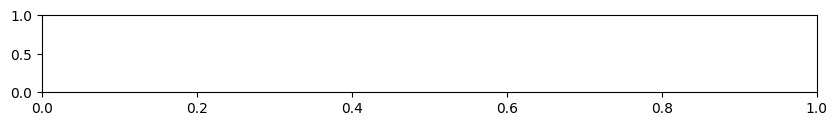

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the following variables defined:
# v_np: numpy array of values
# xor_bits_np: numpy array of XOR bits
# extra_bits: numpy array of extra bits
# bonus_bits: numpy array of bonus bits

plt.figure(figsize=(10, 4))
plt.subplots_adjust(hspace=0.5)

plt.subplot(3, 1, 1)
plt.scatter(v_np, np.zeros_like(v_np), c=xor_bits_np, cmap='OrRd', s=100, alpha=0.3)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.xticks(rotation=45)
plt.gca().yaxis.set_visible(False)
plt.title('XOR Bits')

plt.subplot(3, 1, 2)
plt.scatter(v_np, np.zeros_like(v_np), c=extra_bits, cmap='coolwarm', s=100, alpha=0.3)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.xticks(rotation=45)
plt.gca().yaxis.set_visible(False)
plt.title('Extra Bits')

plt.subplot(3, 1, 3)
plt.scatter(v_np, np.zeros_like(v_np), c=bonus_bits, cmap='coolwarm', s=100, alpha=0.3)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.xticks(rotation=45)
plt.gca().yaxis.set_visible(False)
plt.title('Bonus Bits')

plt.tight_layout()
plt.show()


In [ ]:

for batch in trainloader:
    x0 = batch[:, 0].to(device).float()
    x1 = batch[:, 1].to(device).float()

    v0_B = feature_network(x0).squeeze()
    xor_bits = reduce(x0[: , :5], 'b n -> b', 'sum') % 2
    extra_bits = x0[:, -1]
    
    break


from tabulate import tabulate

# Assuming v0, xor_bits, and extra_bits are already defined as PyTorch tensors

# Convert the tensors to Python lists
v0_list = v0_B.tolist()
xor_bits_list = xor_bits.tolist()
extra_bits_list = extra_bits.tolist()
# Create a list of lists containing the values at each index
table_data = [[i, round(v0_list[i],3), xor_bits_list[i], extra_bits_list[i]] for i in range(len(v0_list))]
# Define the table headers
headers = ["Index", "v0", "xor_bits", "extra_bits"]
# Print the table using tabulate
print(tabulate(table_data, headers, tablefmt="grid"))


# plot v0_list histogram
import matplotlib.pyplot as plt
plt.hist(v0_list, bins=100)
plt.xlabel('v0')



In [ ]:

# find the mutual informatoin between v0 abd v1

critic = GeneralSmileMIEstimator(
    x_dim=config['feature_size'],
    y_dim=config['feature_size'],
    critic_output_size=config['critic_output_size'],
    x_critics_hidden_sizes=[512, 512, 128],
    y_critics_hidden_sizes=[512, 512, 128],
    clip=config['clip'],
    include_bias=config['bias']
).to(device)

critic_optimizer = torch.optim.Adam(
    critic.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)

for _ in range(10):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        x1 = batch[:, 1].to(device).float()

        v0_B = feature_network(x0)
        v1_B = feature_network(x1)

        critic_optimizer.zero_grad()
        MI = critic(v0_B, v1_B)
        loss = -MI
        loss.backward()
        critic_optimizer.step()

        print(MI.item())
        

In [ ]:
# predict the extra_bit_0 from v0

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(config['feature_size'], 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

mlp = MLP().to(device)

mlp_optimizer = torch.optim.Adam(
    mlp.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)

accuracies = []

import matplotlib.pyplot as plt

for _ in range(6):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        # x1 = batch[:, 1].to(device).float()

        v0_B = feature_network(x0)
        extra_bit_0 = x0[:, -1].unsqueeze(1)

        mlp_optimizer.zero_grad()
        extra_bit_pred = mlp(v0_B)
        loss = torch.nn.functional.mse_loss(extra_bit_pred, extra_bit_0)
        loss.backward()
        mlp_optimizer.step()

        print(loss.item())

        # accuracy
        correct = (torch.round(extra_bit_pred) == extra_bit_0).sum().item()

        print(correct / len(extra_bit_0))

        accuracies.append(correct / len(extra_bit_0))

plt.plot(accuracies)
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.title('Extra Bit Prediction Accuracy')
plt.show()

In [ ]:
# predict the xor_bit_0 from v0

mlp = MLP().to(device)

mlp_optimizer = torch.optim.Adam(
    mlp.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)
for _ in range(5):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        x1 = batch[:, 1].to(device).float()

        v0_B = feature_network(x0)
        xor_bits = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)

        mlp_optimizer.zero_grad()
        xor_bits_pred = mlp(v0_B)
        loss = torch.nn.functional.mse_loss(xor_bits_pred, xor_bits)
        loss.backward()
        mlp_optimizer.step()

        print(loss.item())

        # accuracy
        correct = (torch.round(xor_bits_pred) == xor_bits).sum().item()

        print(correct / len(xor_bits))

In [ ]:
# find the mutual informatoin between v1 and xor_bits_1

critic = GeneralSmileMIEstimator(
    x_dim=config['feature_size'],
    y_dim=1,
    critic_output_size=config['critic_output_size'],
    x_critics_hidden_sizes=[1024, 1024, 1024, 512],
    y_critics_hidden_sizes=[1024, 1024, 1024, 512],
    clip=config['clip'],
    include_bias=config['bias']
).to(device)

critic_optimizer = torch.optim.Adam(
    critic.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)


for batch in trainloader:
    # x0 = batch[:, 0].to(device).float()
    x1 = batch[:, 1].to(device).float()

    v1_B = feature_network(x1)
    xor_bits_1 = (reduce(x1[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)

    critic_optimizer.zero_grad()
    MI = critic(v1_B, xor_bits_1)
    loss = -MI
    loss.backward()
    critic_optimizer.step()

    print(MI.item())



In [ ]:
# predict extra_bit_1 from v1

mlp = MLP().to(device)

mlp_optimizer = torch.optim.Adam(
    mlp.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)

for _ in range(5):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        x1 = batch[:, 1].to(device).float()

        v1_B = feature_network(x1)
        extra_bit_1 = x1[:, -1].unsqueeze(1)

        mlp_optimizer.zero_grad()
        extra_bit_pred = mlp(v1_B)
        loss = torch.nn.functional.mse_loss(extra_bit_pred, extra_bit_1)
        loss.backward()
        mlp_optimizer.step()

        print(loss.item())

        # accuracy
        correct = (torch.round(extra_bit_pred) == extra_bit_1).sum().item()

        print(correct / len(extra_bit_1))

In [ ]:
# predict the bonus bit from v0

mlp = MLP().to(device)

mlp_optimizer = torch.optim.Adam(
    mlp.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)
for _ in range(3):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        x1 = batch[:, 1].to(device).float()

        v0_B = feature_network(x0)
        xor_bits = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)
        extra_bit = x0[:, -1].unsqueeze(1)
        bonus_bit = ( xor_bits + extra_bit ) % 2

        mlp_optimizer.zero_grad()
        bonus_bit_pred = mlp(v0_B)
        loss = torch.nn.functional.mse_loss(bonus_bit_pred, bonus_bit)
        loss.backward()
        mlp_optimizer.step()

        print(loss.item())

        # accuracy
        correct = (torch.round(bonus_bit_pred) == bonus_bit).sum().item()

        print(correct / len(bonus_bit))


In [ ]:
# find the mutual information between extra bit and xor bit

critic = GeneralSmileMIEstimator(
    x_dim=1,
    y_dim=1,
    critic_output_size=config['critic_output_size'],
    x_critics_hidden_sizes=[1024, 1024, 1024, 512],
    y_critics_hidden_sizes=[1024, 1024, 1024, 512],
    clip=config['clip'],
    include_bias=config['bias']
).to(device)

critic_optimizer = torch.optim.Adam(
    critic.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)

for _ in range(3):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        x1 = batch[:, 1].to(device).float()

        xor_bits = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)
        extra_bit = x0[:, -1].unsqueeze(1)

        critic_optimizer.zero_grad()
        MI = critic(xor_bits, extra_bit)
        loss = -MI
        loss.backward()
        critic_optimizer.step()

        print(MI.item())

In [ ]:
# find MI between adjacent XOR bits

critic = GeneralSmileMIEstimator(
    x_dim=1,
    y_dim=1,
    critic_output_size=config['critic_output_size'],
    x_critics_hidden_sizes=[1024, 1024, 1024, 512],
    y_critics_hidden_sizes=[1024, 1024, 1024, 512],
    clip=config['clip'],
    include_bias=config['bias']
).to(device)

critic_optimizer = torch.optim.Adam(
    critic.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)

for _ in range(3):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        x1 = batch[:, 1].to(device).float()

        xor_bit0 = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)
        xor_bit1 = (reduce(x1[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)

        critic_optimizer.zero_grad()
        MI = critic(xor_bit0, xor_bit1)
        loss = -MI
        loss.backward()
        critic_optimizer.step()

        print(MI.item())


In [ ]:
# find MI between v0 and extra_bit_0
